In [11]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [12]:
%matplotlib notebook

In [13]:
import freq1

In [23]:
syst = freq1.freq1_class()
syst.struct[0].p_load = 0.5
N_x = syst.N_x
N_y = syst.N_y

x0 = np.zeros(N_x+N_y)
s = sopt.fsolve(syst.run_problem,x0 )
print(f'phi = {s[8]}')
print(f'phi_1 = {s[0]-s[8]}, phi_2 = {s[3]-s[8]}')
print(f'p_1 = {s[6]}, p_2 = {s[8]}')
print(f'omega_1 = {s[1]}, omega_2 = {s[4]}')


phi = 0.25
phi_1 = -4.586609267088615, phi_2 = -4.586609267088615
p_1 = 0.25, p_2 = 0.25
omega_1 = 0.975, omega_2 = 0.975


In [24]:
run = freq1.run
@numba.njit(cache=True) 
def perturbations(t,struct): 
    
    struct[0].p_load = 0.5
    if t>1.0: struct[0].p_load= 0.6
        
    return

        
@numba.njit(cache=True) 
def solver(struct): 
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    i = 0 
    
    Dt = struct[i].Dt 
    N_steps = struct[i].N_steps 
    N_store = struct[i].N_store 
    N_x = struct[i].N_x
    N_y = struct[i].N_y
    N_outs = 1 
    decimation = struct[i].decimation 
    eye = np.eye(N_x)
    # initialization 
    #t = struct[i].t 
    t = 0.0
    run(0.0,struct, 1) 
    it_store = 0 
    struct[i]['T'][0] = t 
    struct[i].X[0,:] = struct[i].x[:,0]  
    
    Y = np.zeros((N_store,N_y))

    

    Y[0,:] = struct[i].y[:,0]  
 
    solver = struct[i].solvern 
    for it in range(N_steps-1): 
        t += Dt 
 
        perturbations(t,struct) 
        
        if solver == 1: 
            # forward euler solver  
            run(t,struct, 2)  
            struct[i].x[:] += Dt*struct[i].f  
 
        if solver == 2: 
            
            # bacward euler solver
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct, 10)  
                phi =  x_0 + Dt*struct[i].f - struct[i].x 
                Dx = np.linalg.solve(-(Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                if np.max(np.abs(Dx)) < struct[i].itol: break 
            print(struct[i].f)
 
        if solver == 3: 
            # trapezoidal solver
            run(t,struct, 2) 
            f_0 = np.copy(struct[i].f[:]) 
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 10)  
                phi =  x_0 + 0.5*Dt*(f_0 + struct[i].f) - struct[i].x 
                Dx = np.linalg.solve(-(0.5*Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                run(t,struct, 2) 
                if np.max(np.abs(Dx)) < struct[i].itol: break 

        if solver == 4: 
            #print(t)
            run(t,struct, 2) 
            run(t,struct, 3) 

            x = np.copy(struct[i].x[:]) 
            y = np.copy(struct[i].y[:]) 
            f = np.copy(struct[i].f[:]) 
            g = np.copy(struct[i].g[:]) 
            
            for iter in range(1):
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct,10) 
                run(t,struct,11) 
                
                x_i = struct[i].x[:] 
                y_i = struct[i].y[:]  
                f_i = struct[i].f[:] 
                g_i = struct[i].g[:]                 
                F_x_i = struct[i].Fx[:,:]
                F_y_i = struct[i].Fy[:,:] 
                G_x_i = struct[i].Gx[:,:] 
                G_y_i = struct[i].Gy[:,:]                

                A_c_i = np.vstack((np.hstack((eye-0.5*Dt*F_x_i, -0.5*Dt*F_y_i)),
                                   np.hstack((G_x_i,         G_y_i))))
                     
                f_n_i = x_i - x - 0.5*Dt*(f_i+f) 
                #print(t,iter,np.linalg.det(G_y_i),struct[i].x[1,0])
                Dxy_i = np.linalg.solve(-A_c_i,np.vstack((f_n_i,g_i))) 
                
                x_i = x_i + Dxy_i[0:N_x]
                y_i = y_i + Dxy_i[N_x:(N_x+N_y)]

                struct[i].x[:] = x_i
                struct[i].y[:] = y_i

                if np.max(np.abs(Dxy_i[:,0]))<1.0e-6:
                    
                    break

            struct[i].x[:] = x_i
            struct[i].y[:] = y_i
                
        # channels 
        if it >= it_store*decimation: 
            struct[i]['T'][it_store+1] = t 
            struct[i].X[it_store+1,:] = struct[i].x[:,0] 
            Y[it_store+1,:] = struct[i].y[:,0]
            it_store += 1 
    struct[i].t = t
    return struct[i]['T'][:], struct[i].X[:], Y 


In [29]:
syst.solvern = 4

syst.t_end = 15.0
syst.Dt = 0.010
syst.decimation =1
syst.update()
syst.struct[0].B_1 = 1
syst.struct[0].B_2 = 10
syst.struct[0].p_load = 0.5

x0 = np.zeros(syst.N_x+syst.N_y)
s = sopt.fsolve(syst.run_problem,x0 )
#syst.struct[0].v_f = 1.2
#syst.struct[0].H = 5
#syst.struct[0].T_pss_1 = 3.6415847004537487              
#syst.struct[0].T_pss_2 = 0.6398979816027691 
#syst.struct[0].D = x_pso[1]
x0 = np.ones((syst.N_x+syst.N_y,1))
s = sopt.fsolve(syst.run_problem,x0 )
syst.struct[0].x[:,0] = s[0:syst.N_x]
syst.struct[0].y[:,0] = s[syst.N_x:]


In [30]:
T,X,Y = solver(syst.struct)

In [32]:
%timeit solver(syst.struct)

9.09 ms ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


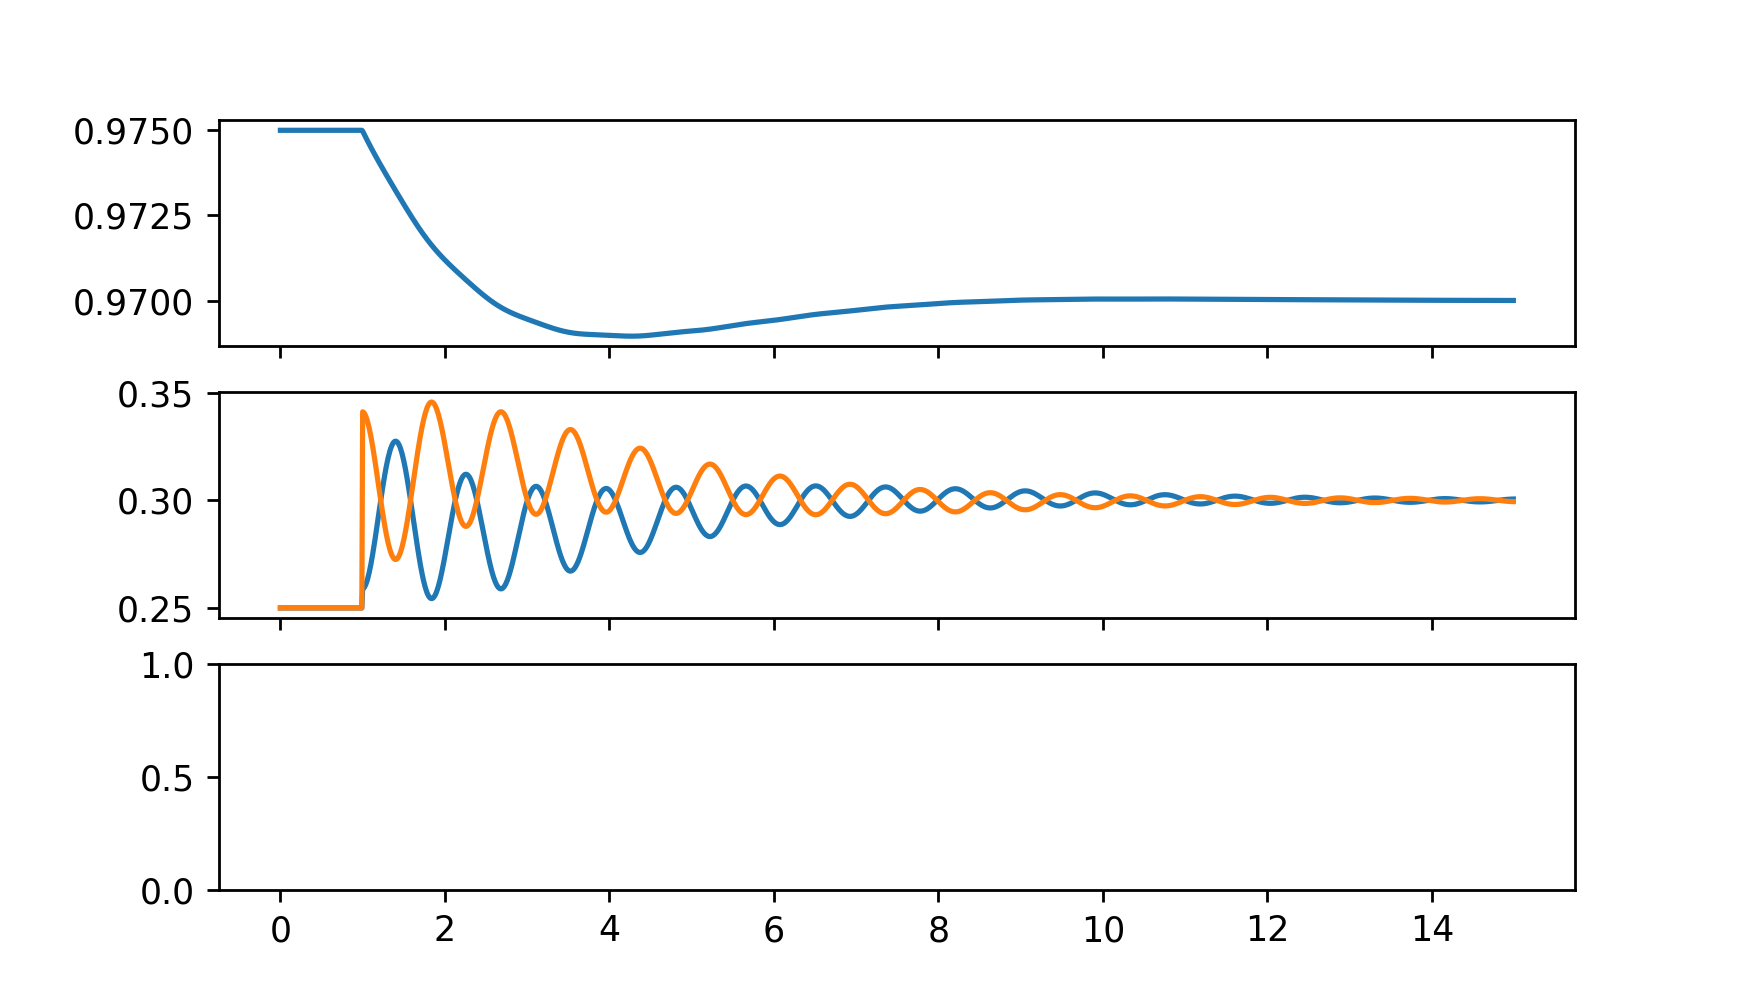

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex = True)
#axes[0].plot(T[:-1], X[:-1,1])
#axes[0].plot(T[:-1], X[:-1,4])
axes[1].plot(T[:-1], Y[:,0])
axes[1].plot(T[:-1], Y[:,2])

axes[0].plot(T[:-1], Y[:,-1])
#axes[1].plot(T[:-1], Y[:,6])

<IPython.core.display.Javascript object>


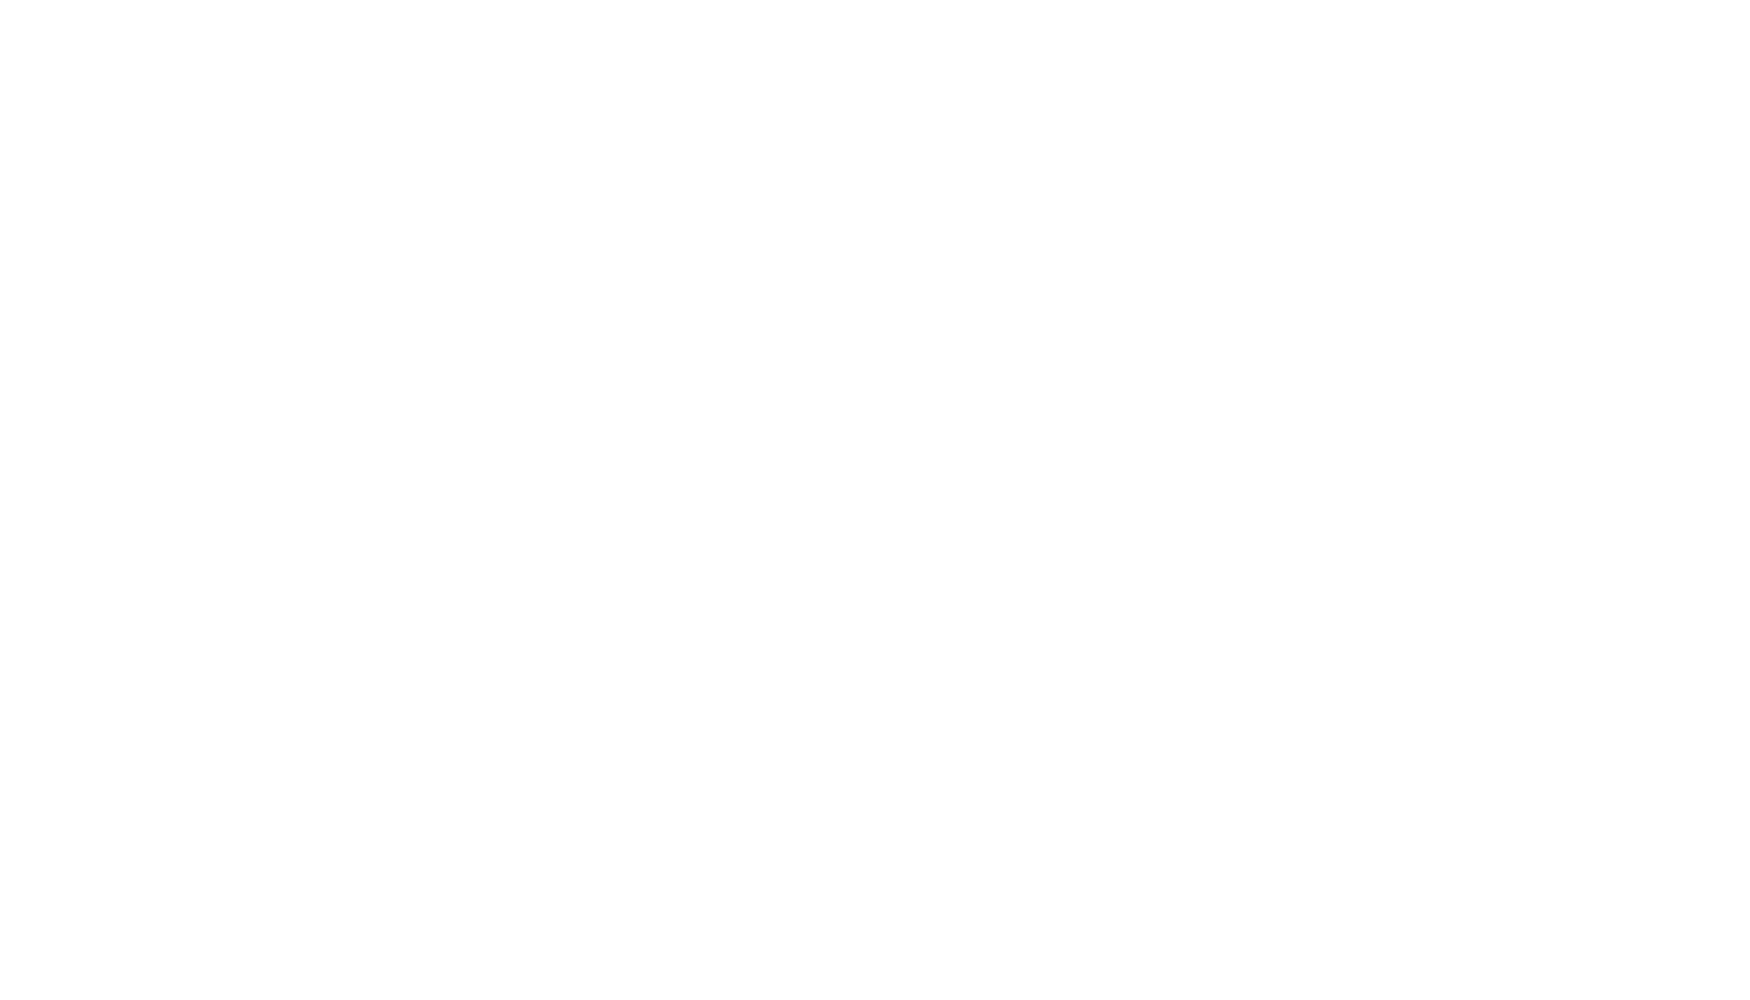

IndexError: index 8 is out of bounds for axis 1 with size 6

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex = True)


axes[0].plot(T[:-1], X[:-1,8])
axes[0].plot(T[:-1], X[:-1,1])
curve1 = axes[1].plot(T[:-1], Y[:,7])
axes[2].plot(T[:-1], Y[:,0])
curve2 = axes[2].plot(T[:-1], Y[:,4]- Y[:,1])
#axes[1].plot(T[:-1], Y[:,3])

axes[1].set_ylim([0,1.2])
#axes[0].set_xlim([0,15])
axes[0].grid(True)
fig.canvas.draw()
def update(p_m = 0.9,T_pss_1 = 1.281,T_pss_2 = 0.013):
    x0 = np.ones((syst.N_x+syst.N_y,1))
    s = sopt.fsolve(syst.ini_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    syst.struct[0].p_m = p_m
    syst.struct[0].T_pss_1 = T_pss_1                
    syst.struct[0].T_pss_2 = T_pss_2                
    T,X,Y = solver(syst.struct)
    curve1[0].set_xdata(T[:-1])
    curve1[0].set_ydata(Y[:,7])
    curve2[0].set_xdata(T[:-1])
    curve2[0].set_ydata(Y[:,4]- Y[:,1])
    fig.canvas.draw()
update()

In [ ]:
interact(update, 
         p_m =widgets.FloatSlider(min=0.0,max=1.2,step=0.1,value=0.8, continuous_update=False),
         T_pss_1 =widgets.FloatSlider(min=0.0,max=10.0,step=0.01,value=1.281, continuous_update=False),
         T_pss_2 =widgets.FloatSlider(min=0.0,max=1.0,step=0.01,value=0.013, continuous_update=False) 
        );

In [ ]:
import operator
import random
import time
import math
import multiprocessing as mp
from deap import base, creator, tools

#def cost_func(part):
#    x1, x2 = part[0], part[1]
#    return ((x1**2+x2**2)**0.25)*((math.sin(50*(x1**2+x2**2)**0.1))**2 +1.0),
s = sopt.fsolve(syst.ini_problem,x0 )
def cost_func(part):
    T_pss_1, T_pss_2 = part[0], part[1]
    x0 = np.ones((syst.N_x+syst.N_y,1))
    
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    syst.struct[0].T_pss_1 = T_pss_1                
    syst.struct[0].T_pss_2 = T_pss_2                
    T,X,Y = solver(syst.struct)
    cost = np.sum((Y[:,0] - (Y[:,4]- Y[:,1]))**2)
    #    a = ((x1**2+x2**2)**0.25)*((math.sin(50*(x1**2+x2**2)**0.1))**2 +1.0)
    return cost,

def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

def updateParticle(best, part, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if speed < part.smin:
            part.speed[i] = part.smin
        elif speed > part.smax:
            part.speed[i] = part.smax
    part[:] = list(map(operator.add, part, part.speed))
    return part

creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best=None)

toolbox = base.Toolbox()
#toolbox.register("particle", generate, size=2, pmin=-10, pmax=10, smin=-2, smax=2)
toolbox.register("particle", generate, size=2, pmin=0.001, pmax=10, smin=0.001, smax=10)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=1.0, phi2=1.0)
toolbox.register("evaluate", cost_func)

def pso(pop,toolbox,maxmov):
    MOVES = maxmov
    best = None
    valor_best = None
    i = 0
    while i < MOVES:
        print('iteracion', i)
        fitnesses = toolbox.map(toolbox.evaluate,pop)
        for part, fit in zip(pop, fitnesses):
             part.fitness.values = fit
        for part in pop:
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
        valor_best1 = best.fitness.values
        if valor_best == valor_best1:
            i += 1
        else:
            valor_best = valor_best1
            i = 0
        for part in pop:
            toolbox.update(best, part)
    return best, best.fitness


In [ ]:
n=10
pop = toolbox.population(n)
MOVES = 80
BestParticle, BestFitness = pso(pop,toolbox,MOVES)
print(BestParticle, BestFitness)
#pool.close()


In [ ]:
from pyswarm import pso
s = sopt.fsolve(syst.ini_problem,x0 )
def cost_func(part):
    T_pss_1, T_pss_2 = part[0], part[1]
    x0 = np.ones((syst.N_x+syst.N_y,1))
    
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    syst.struct[0].T_pss_1 = T_pss_1                
    syst.struct[0].T_pss_2 = T_pss_2                
    T,X,Y = solver(syst.struct)
    cost = np.sum((Y[:,0] - (Y[:,4]- Y[:,1]))**2)
    #    a = ((x1**2+x2**2)**0.25)*((math.sin(50*(x1**2+x2**2)**0.1))**2 +1.0)
    return cost



lb = [1, 1]
ub = [5, 5]

xopt, fopt = pso(cost_func, lb, ub)

In [ ]:
from scipy import optimize


In [ ]:
s = sopt.fsolve(syst.ini_problem,x0 )
def cost_func(part):
    T_pss_1, T_pss_2 = part[0], part[1]
    x0 = np.ones((syst.N_x+syst.N_y,1))
    
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    syst.struct[0].T_pss_1 = T_pss_1                
    syst.struct[0].T_pss_2 = T_pss_2                
    T,X,Y = solver(syst.struct)
    cost = np.sum((Y[:,0] - (Y[:,4]- Y[:,1]))**2)
    #    a = ((x1**2+x2**2)**0.25)*((math.sin(50*(x1**2+x2**2)**0.1))**2 +1.0)
    return cost

bnds = ((1, 5), (2, 5))
res = optimize.minimize(cost_func, (2, 2), method='COBYLA', bounds=bnds)

In [ ]:
res

In [ ]:
s